# K-Rotas - Rotogram suggestions
This notebook is responsible for analysis and suggest changes on rotograms

In [1]:
import json
import os
import geopy.distance
import random
import matplotlib.pyplot as plt
import math
from math import degrees
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
import pandas as pd
from operator import itemgetter
from scipy.signal import savgol_filter

In [2]:
TRIPS_GEOJSON_FILE_TV = "tripsGeojsonTV/"
TRIPS_GEOJSON_FILE_TC = "tripsGeojsonTC/"
ROTOGRAMS_MESHS_FILES = "rotograms_meshs/"
ROTOGRAMS_FILES = "rotograms/"
HEAT_MAPS_DIRECTORY = "heatMapsSuggestions/"
HEAT_CLUSTERS_DIRECTORY = "heatClusters/"
ORDER_CLUSTERS_DIRECTORY = "heatOrderCluster/"
ORDER_CLUSTERS_LINES_DIRECTORY = "heatOrderLines/"
MERGED_ROTOGRAMS_DIRECTORY = "mergedRotograms/"
MERGED_GEOJSON_ROTOGRAMS_DIRECTORY = "mergedGeojsonRotograms/"

DISTANCE_METERS_TO_BE_IN_LINE = 8
DISTANCE_METERS_TO_BE_CONECTED_TO_ROUTE = 30
DISTANCE_BETWEEN_EACH_POINTS_PATH = 5

In [3]:
rotogramsMeshDict = {}
rotogramsDict = {}
tripsEmptyDict = {}
tripsFullDict = {}

In [4]:
def makeNewPoint(geoJsonPoint):
    return (geoJsonPoint[1], geoJsonPoint[0])

def makeVector(pointA, pointB):
    return [pointB[0] - pointA[0], pointB[1] - pointA[1]]

def distanceMeteres(point1, point2):
    return geopy.distance.geodesic(point1, point2).km * 1000

def angleBetweenVectors(vector1, vector2):
    unit_vector_1 = vector1 / np.linalg.norm(vector1)
    unit_vector_2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    angleDegress = degrees(angle)
    
    return angleDegress

def writeJsonFile(filename, data):
    with open(filename, 'w') as file:
        json.dump(data, file)

In [33]:
class LineSegment:
    def __init__(self, pointA: tuple, pointB: tuple):
        self.pointA = pointA
        self.pointB = pointB
        
    def isPointInLine(self, point, distanceInMetersToBeInLine):
        distancePointToSegmentLine = self.__getDistancePointToLineSegment(point)
        
        if self.__isPointCloseToLineSegment(distancePointToSegmentLine, distanceInMetersToBeInLine):
            if self.__isPointOnLineLaterals(point):
                return True
        return False
    
    def __isPointCloseToLineSegment(self, distancePointToSegmentLine, distanceInMetersToBeInLine):
        return distancePointToSegmentLine <= distanceInMetersToBeInLine
    
    def __getDistancePointToLineSegment(self, point):
        closetsPointInLineSegment = self.__closestPointInLine(point)
        return distanceMeteres(point, closetsPointInLineSegment)
    
    def __isPointOnLineLaterals(self, point):
        vectorAP = makeVector(self.pointA, point)
        vectorAB = makeVector(self.pointA, self.pointB)
        
        vectorBP = makeVector(self.pointB, point)
        vectorBA = makeVector(self.pointB, self.pointA)
        
        angleAPAB = angleBetweenVectors(vectorAP, vectorAB)
        angleBPBA = angleBetweenVectors(vectorBP, vectorBA)
        return angleAPAB <= 90 and angleBPBA <= 90

    #https://stackoverflow.com/questions/3120357/get-closest-point-to-a-line
    def __closestPointInLine(self, point):
        a_to_p = [1,1]
        a_to_b = [1,1]

        a_to_p[0] = point[0] - self.pointA[0]
        a_to_p[1] = point[1] - self.pointA[1]
        a_to_b[0] = self.pointB[0] - self.pointA[0]
        a_to_b[1] = self.pointB[1] - self.pointA[1]

        atb2 = a_to_b[0] * a_to_b[0] + a_to_b[1] * a_to_b[1]
        atp_dot_atb = a_to_p[0] * a_to_b[0] + a_to_p[1] * a_to_b[1]
        
        t = 0
        if atb2 == 0:
            t = 1
        else:
            t = atp_dot_atb / atb2;

        if (t > 1): t = 1
        if (t < 0): t = 0

        return (self.pointA[0] + a_to_b[0] * t, self.pointA[1] + a_to_b[1] * t)
    
class RoadMesh:
    # roadMesh: json decoded road mesh file
    def __init__(self, rotogramMesh):
        self.distanceLines = rotogramMesh["distanceLines"]
        self.minPointLat = rotogramMesh["minPointLat"]
        self.maxPointLat = rotogramMesh["maxPointLat"]
        self.numberOfLines = rotogramMesh["numberOfLines"]
        self.listLines = rotogramMesh["listLines"]
        self.realDistanceBetweenEachLine = rotogramMesh["realDistanceBetweenEachLine"]

    # point = Tuple (lat, lng)
    def isInRoute(self, point, DISTANCE):
        listEdges = self.__getListEdges(point)

        if len(listEdges) == 0:
            return False

        return self.__isNearRoute(point, listEdges, DISTANCE)
    
    # point = Tuple (lat, lng)
    def isAtLeastDistanceFromRoute(self, point, DISTANCE):
        listEdges = self.__getListEdgesTopAndAbove(point)
        
        if len(listEdges) == 0:
            return False

        return self.__isNearRoute(point, listEdges, DISTANCE)

    def __isNearRoute(self, point, listEdges, DISTANCE):
        for edge in listEdges:
            pointA = (edge["pointA"]["lat"], edge["pointA"]["lng"])
            pointB = (edge["pointB"]["lat"], edge["pointB"]["lng"])

            lineSegment = LineSegment(pointA, pointB)

            if lineSegment.isPointInLine(point, DISTANCE):
                return True

        return False
    
    #The list of the nearest points
    def __getListEdges(self, point):
        lineIndex = self.__getLine(point, self.realDistanceBetweenEachLine, self.minPointLat)

        if lineIndex >= 0 and lineIndex < len(self.listLines):
            return self.listLines[lineIndex]
        else:
            return []
        
    def __getListEdgesTopAndAbove(self, point):
        lineIndex = self.__getLine(point, self.realDistanceBetweenEachLine, self.minPointLat)
        
        listEdges = []
        
        if lineIndex >= 0 and lineIndex < len(self.listLines):
            listEdges.extend(self.listLines[lineIndex])
        
        if lineIndex + 1 >= 0 and lineIndex + 1 < len(self.listLines):
            listEdges.extend(self.listLines[lineIndex + 1])
            
        if lineIndex - 1 >= 0 and lineIndex - 1 < len(self.listLines):
            listEdges.extend(self.listLines[lineIndex - 1])
        
        return listEdges

    def __canGoThere(self, latIndex, lngIndex):
        return latIndex >= 0 and lngIndex >= 0 and latIndex < self.linesLatitude and lngIndex < self.linesLongitude

    def __getLine(self, point, distLines, minPointLat):
        actualPoint = (point[0], 0)
        minP = (minPointLat, 0)

        distPointMin = geopy.distance.geodesic(actualPoint, minP).meters
        return int(distPointMin / distLines)

In [34]:
def readJsonFile(filename, DIRECTORY):
    fileContent = open(os.path.join(DIRECTORY, filename), 'r')
    return json.loads(fileContent.read())

# ROTOGRAMS
def getOriginRotogramFileName(filename):
    return filename.split(".")[0].split("_")[0]

def getBlockRotogramFileName(filename):
    return filename.split(".")[0].split("_")[1]

def addRotogramToMeshDict(origin, block, rotogramDataJson):
    if not origin in rotogramsMeshDict:
        rotogramsMeshDict[origin] = {}
        
    rotogramsMeshDict[origin][block] = RoadMesh(rotogramDataJson)
    
def addRotogramToDict(origin, block, rotogramDataJson):
    if not origin in rotogramsDict:
        rotogramsDict[origin] = {}
        
    rotogramsDict[origin][block] = rotogramDataJson

def loadRotograms():
    for rotogramFileName in os.listdir(ROTOGRAMS_MESHS_FILES):
        if(rotogramFileName == ".gitkeep"): continue
        rotogramContent = readJsonFile(rotogramFileName, ROTOGRAMS_MESHS_FILES)
        
        origin = getOriginRotogramFileName(rotogramFileName)
        block = getBlockRotogramFileName(rotogramFileName)
        
        addRotogramToMeshDict(origin, block, rotogramContent)
        
    for rotogramFileName in os.listdir(ROTOGRAMS_FILES):
        if(rotogramFileName == ".gitkeep"): continue
        rotogramContent = readJsonFile(rotogramFileName, ROTOGRAMS_FILES)
        
        origin = getOriginRotogramFileName(rotogramFileName)
        block = getBlockRotogramFileName(rotogramFileName)
        
        addRotogramToDict(origin, block, rotogramContent)

# TRIPS
def getOriginTripFileName(filename):
    return filename.split(".")[0].split("_")[0]

def getDestinationTripFileName(filename):
    return filename.split(".")[0].split("_")[3]

def getBlockTripFileName(filename):
    return filename.split(".")[0].split("_")[2]

def addTripToEmptyRouteList(origin, block, tripContent):
    if not origin in tripsEmptyDict:
        tripsEmptyDict[origin] = {}
        
    if not block in tripsEmptyDict[origin]:
        tripsEmptyDict[origin][block] = []
        
    tripsEmptyDict[origin][block].append(tripContent)

def addTripToFullRouteList(destination, block, tripContent):
    if not destination in tripsFullDict:
        tripsFullDict[destination] = {}
        
    if not block in tripsFullDict[destination]:
        tripsFullDict[destination][block] = []
        
    tripsFullDict[destination][block].append(tripContent)

def addTripTV(tripFileName, tripDataJson):
    origin = getOriginTripFileName(tripFileName)
    block = getBlockTripFileName(tripFileName)
    
    addTripToEmptyRouteList(origin, block, tripDataJson)
    
def addTripTC(tripFileName, tripDataJson):
    block = getBlockTripFileName(tripFileName)
    destination = getDestinationTripFileName(tripFileName)
    
    addTripToFullRouteList(destination, block, tripDataJson)

def loadTrips():
    for tripFileName in os.listdir(TRIPS_GEOJSON_FILE_TV):
        if(tripFileName == ".gitkeep"): continue
        tripContent = readJsonFile(tripFileName, TRIPS_GEOJSON_FILE_TV)
        addTripTV(tripFileName, tripContent)
        
    for tripFileName in os.listdir(TRIPS_GEOJSON_FILE_TC):
        if(tripFileName == ".gitkeep"): continue
        tripContent = readJsonFile(tripFileName, TRIPS_GEOJSON_FILE_TC)
        addTripTC(tripFileName, tripContent)

### Common code

In [35]:
def plotRoutes(rotogram, listTracersPoints, origin, block, acutalPath):
    latitudeRotogram = []
    longitudeRotogram = []
    
    latitudeHeatMap = []
    longitudeHeatMap = []

    rotogramPoints = rotogram["features"][0]["geometry"]["coordinates"]
    
    for i in range(0, len(rotogramPoints)):
        longitudeRotogram.append(float(rotogramPoints[i][0]))
        latitudeRotogram.append(float(rotogramPoints[i][1]))
    
    listPoints = [item for sublist in listTracersPoints for item in sublist]
    for i in range(0, len(listPoints)):
        longitudeHeatMap.append(float(listPoints[i][0]))
        latitudeHeatMap.append(float(listPoints[i][1]))

    #Plota
    figId = random.randint(0, 10000000000000000)
    plt.figure(figId)
    
    plt.scatter(latitudeHeatMap, longitudeHeatMap, s=0.001,color="red", alpha=0.1)
#     olor=['red','green','blue']
    plt.plot(latitudeRotogram, longitudeRotogram, label='Rotograma',linewidth=0.2)
    
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()

    plt.title(origin+"_"+block+"_"+acutalPath)
    plt.savefig(HEAT_MAPS_DIRECTORY+origin+"_"+block+"_"+acutalPath+'.svg', dpi=6000)
    


In [36]:
loadRotograms()
loadTrips()

### Mark points out of route

In [37]:
def existsTripsForRotogram(originOrDestination, block, tripsDict):
    if not originOrDestination in tripsDict: return False
    if not block in tripsDict[originOrDestination]: return False
    if len(tripsDict[originOrDestination][block]) == 0: return False
    return True

def getFullListOfTracersPoints(travels, actualPath):
    fullListPoints = []
    
    for travel in travels:
        fullListPoints.append(travel["tracers"][actualPath]["geometry"]["coordinates"])
    
    return fullListPoints

def getListTracersWithPoints(origin, block, actualPath):
    if actualPath == "TRAJETO_VAZIO":
        if not existsTripsForRotogram(origin, block, tripsEmptyDict): return []
        travels = tripsEmptyDict[origin][block]
        return getFullListOfTracersPoints(travels, actualPath)
    else:
        if not existsTripsForRotogram(origin, block, tripsFullDict): return []
        travels = tripsFullDict[origin][block]
        return getFullListOfTracersPoints(travels, actualPath)

def filterListTracersPointsOutsideRoute(listTracerPoints, rotogram):
    newListTracersPointsFilteres = []
    
    for tracer in listTracerPoints:
        newTracerPointsList = []
    
        for point in tracer:
            newPoint = makeNewPoint(point)

            if not rotogram.isInRoute(newPoint, DISTANCE_METERS_TO_BE_IN_LINE):
                newTracerPointsList.append(point)
                
        newListTracersPointsFilteres.append(newTracerPointsList)
            
    return newListTracersPointsFilteres
    
#Temporary
def markPointOutsideRoute(actualPath):
    jsonPointsOutRoute = {}
    counter = 1
    for origin in rotogramsMeshDict:
        for block in rotogramsMeshDict[origin]:
            print(counter, "/", len(rotogramsMeshDict) * len(rotogramsMeshDict[origin]))
            counter+=1
            rotogram = rotogramsMeshDict[origin][block]

            listTracersPointsEmptyPath = getListTracersWithPoints(origin, block, actualPath)
            if len(listTracersPointsEmptyPath) > 0:
                tracersPointsOutOfRoute = filterListTracersPointsOutsideRoute(listTracersPointsEmptyPath, rotogram)
                
                if len(tracersPointsOutOfRoute) > 0:
                    jsonPointsOutRoute[origin+"_"+block] = tracersPointsOutOfRoute
#                     plotRoutes(rotogramsDict[origin][block], tracersPointsOutOfRoute, origin, block, actualPath)
    return jsonPointsOutRoute

In [68]:
tracersPointsOutRoute = markPointOutsideRoute("TRAJETO_VAZIO")
writeJsonFile("tracersPointsOutRouteTV.json", tracersPointsOutRoute)
tracersPointsOutRoute = markPointOutsideRoute("TRAJETO_CARREGADO")
writeJsonFile("tracersPointsOutRouteTC.json", tracersPointsOutRoute)

1 / 120
2 / 120
3 / 120
4 / 120
5 / 120
6 / 120
7 / 120
8 / 120
9 / 120
10 / 120
11 / 120
12 / 120
13 / 120
14 / 120
15 / 120
16 / 120
17 / 120
18 / 120
19 / 120
20 / 120
21 / 120
22 / 120
23 / 120
24 / 120
25 / 120
26 / 120
27 / 120
28 / 120
29 / 120
30 / 120
31 / 120
32 / 120
33 / 120
34 / 120
35 / 120
36 / 120
37 / 120
38 / 120
39 / 120
40 / 120
41 / 120
42 / 120
43 / 120
44 / 120
45 / 120
46 / 120
47 / 120
48 / 120
49 / 120
50 / 120
51 / 120
52 / 120
53 / 120
54 / 120
55 / 120
56 / 120
57 / 120
58 / 120
59 / 120
60 / 120
61 / 120
62 / 120
63 / 120
64 / 120
65 / 120
66 / 120
67 / 120
68 / 120
69 / 120
70 / 120
71 / 120
72 / 120
73 / 120
74 / 120
75 / 120
76 / 120
77 / 120
78 / 120
79 / 120
80 / 120
81 / 120
82 / 120
83 / 120
84 / 120
85 / 120
86 / 120
87 / 120
88 / 120
89 / 120
90 / 120
91 / 120
92 / 120
93 / 120
94 / 120
95 / 120
96 / 120
97 / 120
98 / 120
99 / 120
100 / 120
101 / 120
102 / 120
103 / 120
104 / 120
105 / 120
106 / 120
107 / 120
108 / 120
109 / 120
110 / 120
111 / 12

In [38]:
tracersTV = readJsonFile("tracersPointsOutRouteTV.json", "./")
tracersTC = readJsonFile("tracersPointsOutRouteTC.json", "./")

### Cluster the points

In [39]:
def dbscan(listPoints):
    headers = ["Lat", "Long"]
    df = pd.DataFrame(listPoints, columns=headers)
#     df = StandardScaler().fit_transform(df)
    
    db = DBSCAN(eps=0.07/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(df))
    labels = db.labels_
    return labels
    

In [40]:

def getClusterOfPoint(listClusters, point):
    for cluster in listClusters:
        if cluster.isNearToCluster(point):
            if cluster.belongsToCluster(point):
                return cluster
    newCluster = ClusterPoints()
    listClusters.append(newCluster)
    return newCluster

def writeDictOfClustersToJson(jsonClusters, filename):
    newJsonClusters = {}
    
    for roto in jsonClusters:
        newJsonClusters[roto] = []
        for cluster in jsonClusters[roto]:
            newJsonClusters[roto].append(cluster.points)
    
    writeJsonFile(filename, newJsonClusters)
    
def joinAllTracersInSingleList(tracers):
    return [item for sublist in tracers for item in sublist]

def clusterizationAlgorithm(listPoints):
    dictClusters = {}
    listOfClusters = []
    
    clusters = dbscan(listPoints)
    
    for i in range(0, len(listPoints)):
        point = listPoints[i]
        clusterOfPoint = clusters[i]
        
        #noise
        if clusterOfPoint == -1: continue
            
        if not clusterOfPoint in dictClusters:
            dictClusters[clusterOfPoint] = []
        
        dictClusters[clusterOfPoint].append(point)
        
    for cluster in dictClusters:
        listOfClusters.append(dictClusters[cluster])
    
    return listOfClusters

def getListOfClustersOfRotogram(tracers, dictOfClusters):
    clustersList = []
    lastCluster = None
    
    listOfPointsInTracers = joinAllTracersInSingleList(tracers)
    
    res = tuple(tuple(sub) for sub in listOfPointsInTracers)
    if len(listOfPointsInTracers) != len(set(res)):
        print("Before", len(listOfPointsInTracers))
        print("After", len(set(res)))
    
    listOfClusters = clusterizationAlgorithm(listOfPointsInTracers)
    
    return listOfClusters
    
def filterClusterDisconectedToRotogram(listClusters, rotogramMesh):
    filteredListOfClusters = []
    
    for cluster in listClusters:
        for point in cluster:
            newPoint = makeNewPoint(point)

            if rotogramMesh.isAtLeastDistanceFromRoute(newPoint, DISTANCE_METERS_TO_BE_CONECTED_TO_ROUTE):
                filteredListOfClusters.append(cluster)
                break
    
    return filteredListOfClusters
        

In [41]:
def makeClusters(tracers):
    dictOfClusters = {}
    
    counter = 1
    
    for rotogram in tracers:
        print(counter, "/", len(tracers))
        counter += 1
        
        origin = rotogram.split("_")[0]
        block = rotogram.split("_")[1]
        
        listOfClusters = getListOfClustersOfRotogram(tracers[rotogram], dictOfClusters)
        
        rotogramMesh = rotogramsMeshDict[origin][block]
        
        listOfClustersFiltered = filterClusterDisconectedToRotogram(listOfClusters, rotogramMesh)
        
        dictOfClusters[rotogram] = listOfClustersFiltered
        
    return dictOfClusters

In [42]:
jsonClusters = makeClusters(tracersTV)
# writeDictOfClustersToJson(jsonClusters, "clustersTV.json")
writeJsonFile("clustersTV.json", jsonClusters)

jsonClusters = makeClusters(tracersTC)
# writeDictOfClustersToJson(jsonClusters, "clustersTC.json")
writeJsonFile("clustersTC.json", jsonClusters)

1 / 29
Before 330
After 165
2 / 29
Before 440
After 210
3 / 29
Before 2870
After 1435
4 / 29
Before 8506
After 4068
5 / 29
Before 2698
After 1349
6 / 29
Before 11132
After 5455
7 / 29
Before 14578
After 7247
8 / 29
Before 5142
After 2571
9 / 29
Before 2848
After 1402
10 / 29
Before 1224
After 596
11 / 29
Before 6336
After 3034
12 / 29
Before 1616
After 808
13 / 29
Before 1534
After 747
14 / 29
Before 1064
After 531
15 / 29
Before 542
After 270
16 / 29
Before 2776
After 1340
17 / 29
Before 1018
After 497
18 / 29
Before 320
After 160
19 / 29
Before 1208
After 582
20 / 29
Before 1092
After 546
21 / 29
Before 6640
After 3312
22 / 29
Before 4508
After 2254
23 / 29
Before 4960
After 2435
24 / 29
Before 5966
After 2959
25 / 29
Before 810
After 400
26 / 29
Before 758
After 379
27 / 29
Before 498
After 249
28 / 29
Before 1994
After 997
29 / 29
Before 4010
After 1957
1 / 23
Before 1898
After 949
2 / 23
Before 1890
After 945
3 / 23
Before 1808
After 904
4 / 23
Before 2288
After 1126
5 / 23
Before

In [43]:
def plotClusters(rotogram, listClusters, origin, block, acutalPath):
    #Plota
    figId = random.randint(0, 10000000000000000)
    plt.figure(figId)
    
    colors = ["red", "green", "orange", "gray", "black", "purple", "Yellow", "Brown", "Pink", "Lime"]
    
    latitudeRotogram = []
    longitudeRotogram = []

    rotogramPoints = rotogram["features"][0]["geometry"]["coordinates"]
    
    for i in range(0, len(rotogramPoints)):
        longitudeRotogram.append(float(rotogramPoints[i][0]))
        latitudeRotogram.append(float(rotogramPoints[i][1]))
    
    for cluster in listClusters:
        latitudeCluster = []
        longitudeCluster = []
        
        for i in range(0, len(cluster)):
            longitudeCluster.append(float(cluster[i][0]))
            latitudeCluster.append(float(cluster[i][1]))
            
        plt.scatter(latitudeCluster, longitudeCluster, s=0.001, color=random.choice(colors), alpha=0.1)
    
#     olor=['red','green','blue']
    plt.plot(latitudeRotogram, longitudeRotogram, color="blue", label='Rotograma',linewidth=0.2)
    
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()

    plt.title(origin+"_"+block+"_"+acutalPath)
    plt.savefig(HEAT_CLUSTERS_DIRECTORY+origin+"_"+block+"_"+acutalPath+'.svg', dpi=6000)

/home/brunolippert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


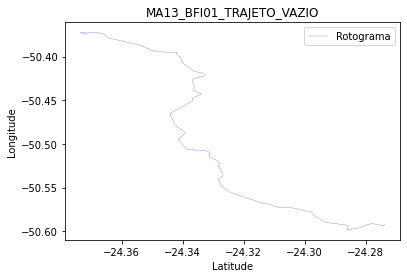

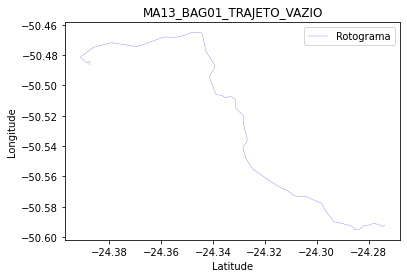

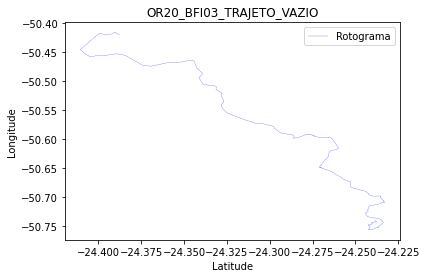

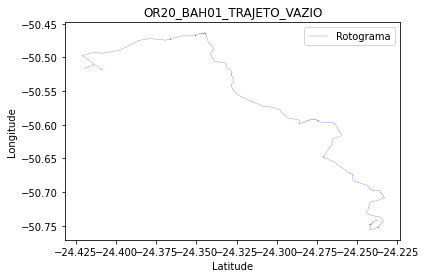

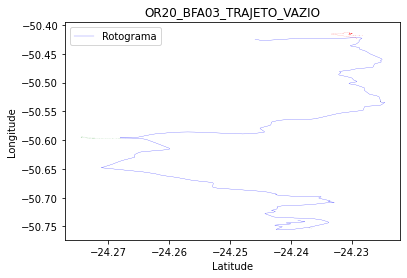

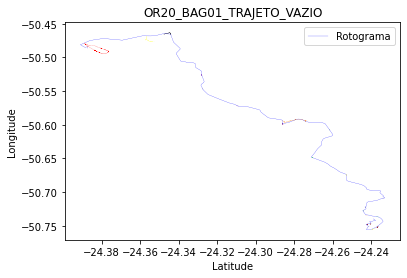

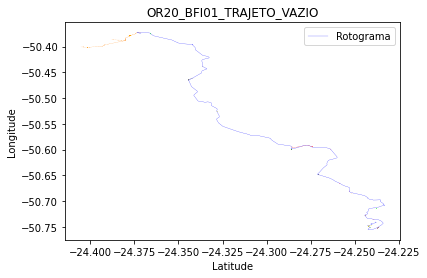

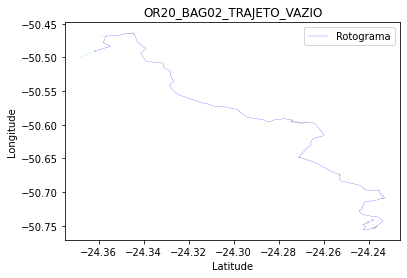

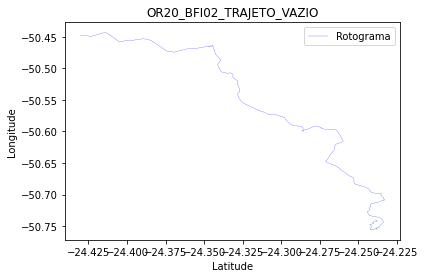

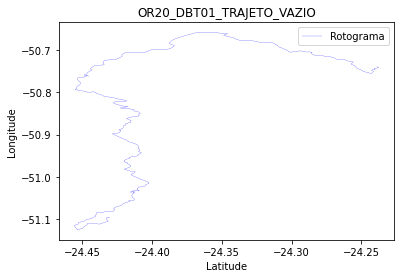

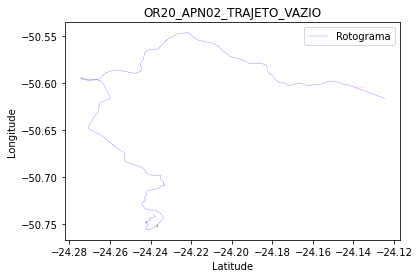

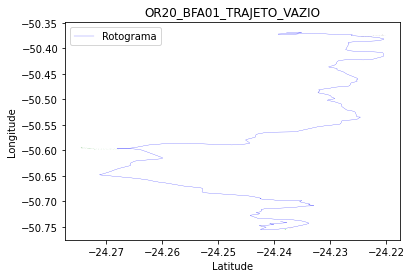

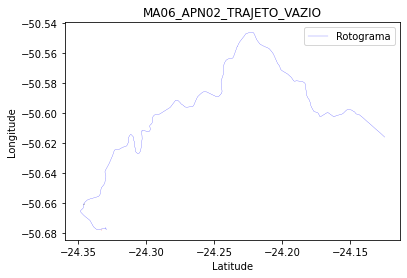

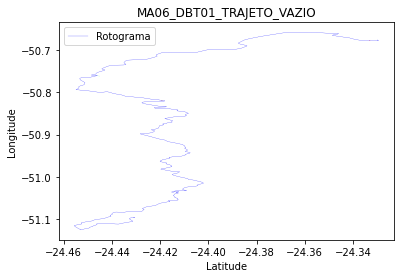

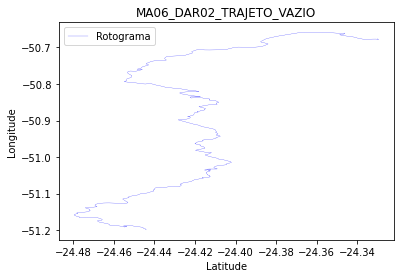

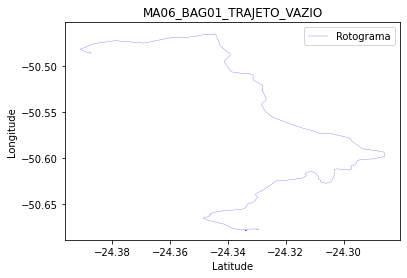

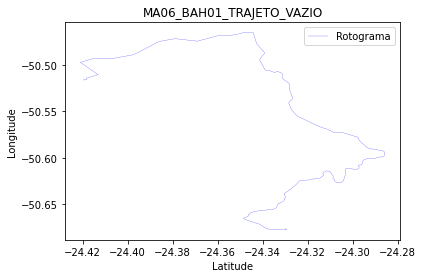

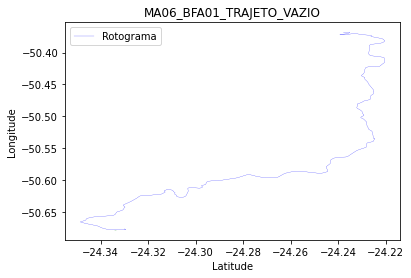

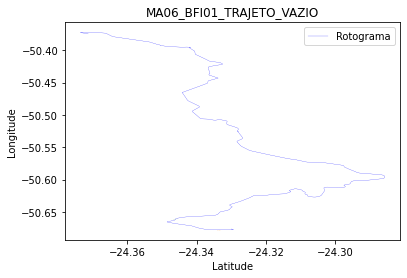

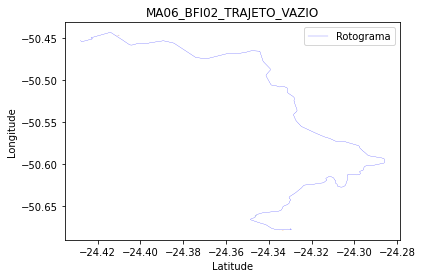

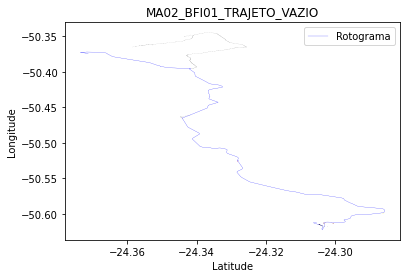

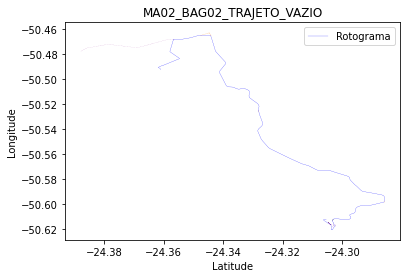

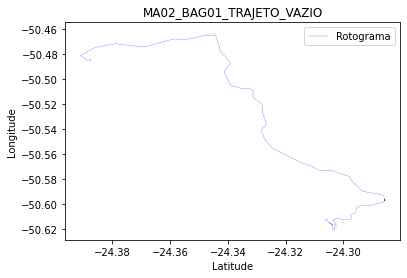

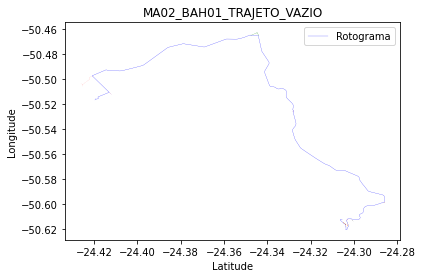

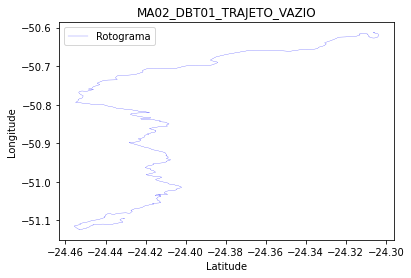

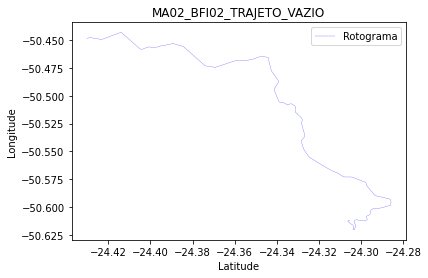

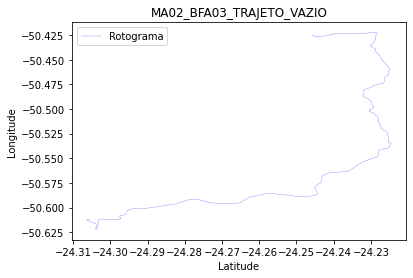

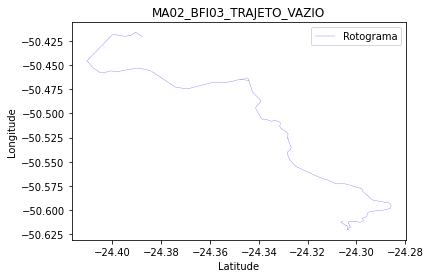

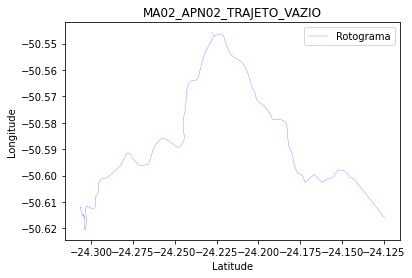

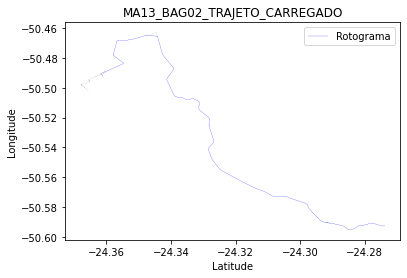

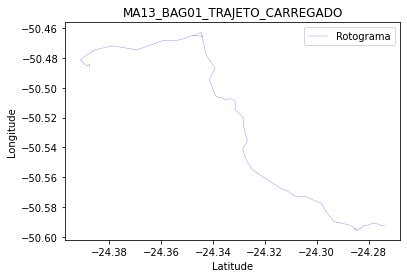

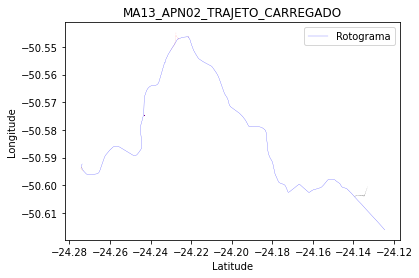

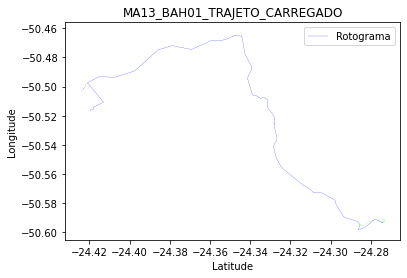

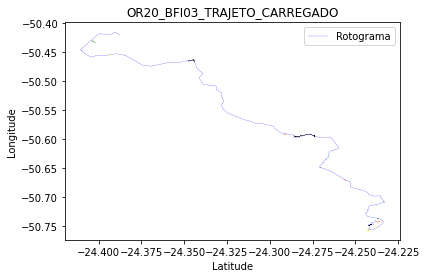

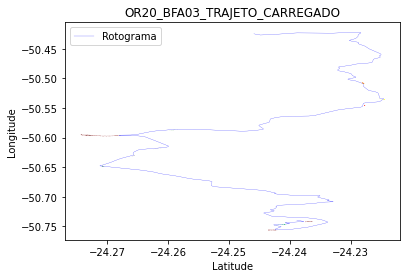

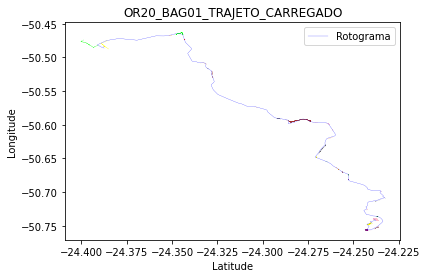

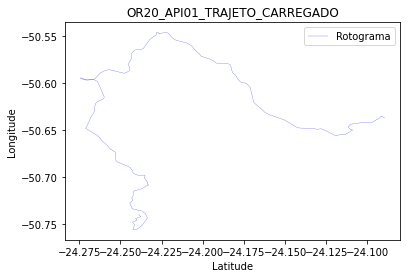

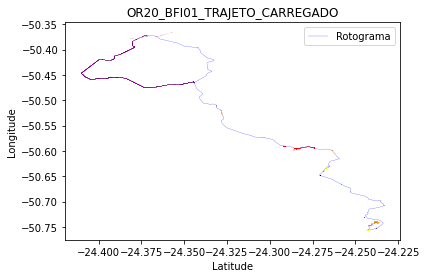

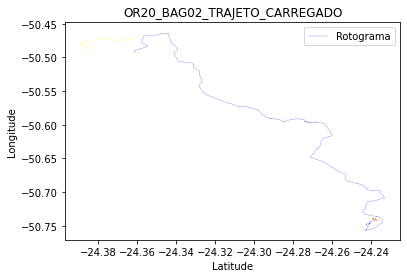

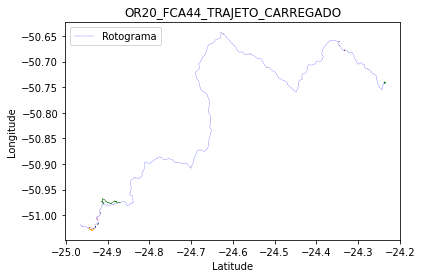

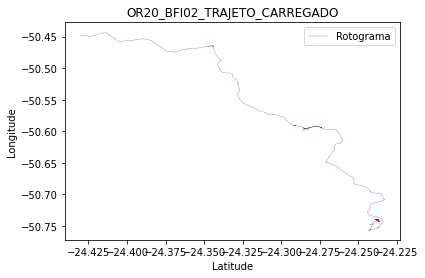

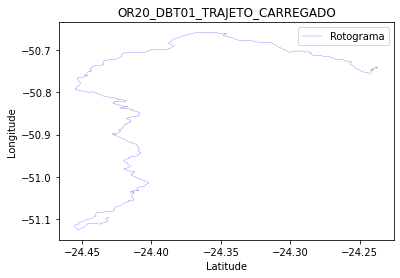

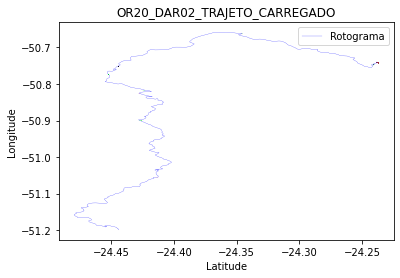

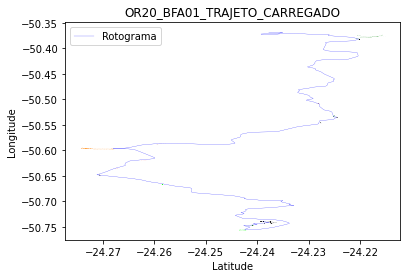

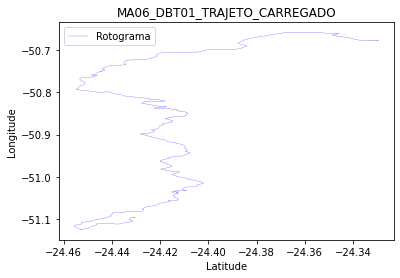

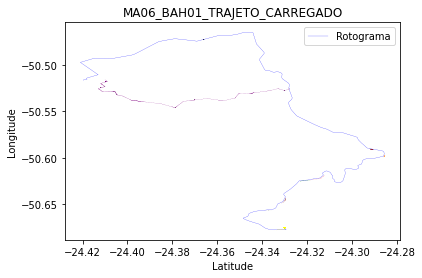

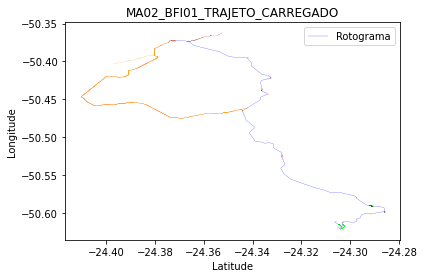

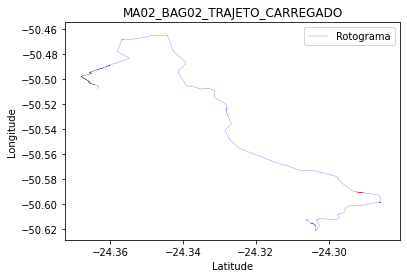

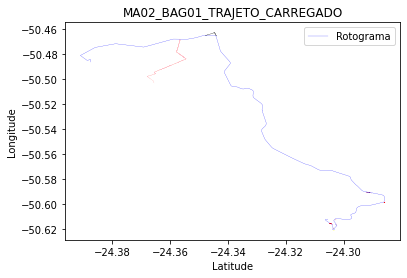

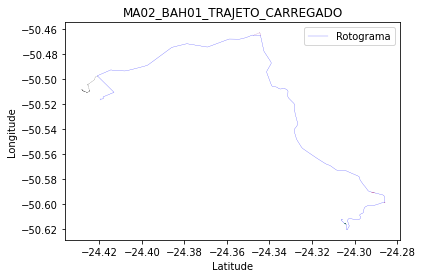

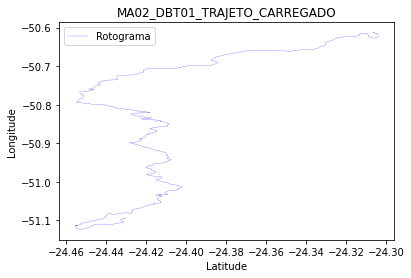

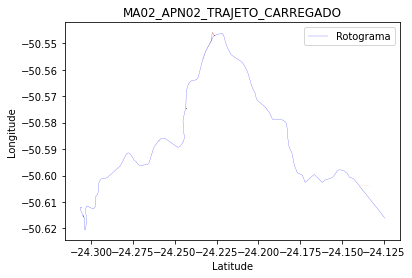

In [44]:
clustersTV = readJsonFile("clustersTV.json", "./")
clustersTC = readJsonFile("clustersTC.json", "./")

for rotogramName in clustersTV:
    origin = rotogramName.split("_")[0]
    block = rotogramName.split("_")[1]
    
    rotogram = rotogramsDict[origin][block]
    plotClusters(rotogram, clustersTV[rotogramName], origin, block, "TRAJETO_VAZIO")

for rotogramName in clustersTC:
    origin = rotogramName.split("_")[0]
    block = rotogramName.split("_")[1]
    
    rotogram = rotogramsDict[origin][block]
    plotClusters(rotogram, clustersTC[rotogramName], origin, block, "TRAJETO_CARREGADO")

### Filter and get order of points using tracers

In [45]:
def plotClusterOrder(rotogram, cluster, clusterPoints, origin, block, acutalPath, i):
    #Plota
    figId = random.randint(0, 10000000000000000)
    plt.figure(figId)
    
    colors = ["red", "green", "orange", "gray", "black", "purple", "Yellow", "Brown", "Pink", "Lime"]
    
    latitudeRotogram = []
    longitudeRotogram = []

    rotogramPoints = rotogram["features"][0]["geometry"]["coordinates"]
    
    for i in range(0, len(rotogramPoints)):
        longitudeRotogram.append(float(rotogramPoints[i][0]))
        latitudeRotogram.append(float(rotogramPoints[i][1]))
    
    latitudeCluster = []
    longitudeCluster = []

    for i in range(0, len(cluster)):
        longitudeCluster.append(float(cluster[i][0]))
        latitudeCluster.append(float(cluster[i][1]))
    
    latitudeClusterP = []
    longitudeClusterP = []

#     for i in range(0, len(clusterPoints)):
#         longitudeClusterP.append(float(clusterPoints[i][0]))
#         latitudeClusterP.append(float(clusterPoints[i][1]))

#     
    
#     olor=['red','green','blue']
    plt.plot(latitudeRotogram, longitudeRotogram, color="blue", label='Rotograma',linewidth=0.2)
    plt.plot(latitudeCluster, longitudeCluster, color="red", label='Cluster',linewidth=0.2)
    plt.scatter(latitudeCluster, longitudeCluster, s=0.001, color="purple", alpha=0.4)
    
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()

    plt.title(origin+"_"+block+"_"+acutalPath+str(i))
    plt.savefig(ORDER_CLUSTERS_DIRECTORY+origin+"_"+block+"_"+acutalPath+str(i)+'.svg', dpi=6000)
    plt.close(figId)

In [46]:
class Cluster:
    def __init__(self, clusterPoints, clusterRotogram):
        self.clusterPoints = clusterPoints
        self.clusterDictPoints = self.transformListPointsInDict(clusterPoints)
        self.clusterRotogram = clusterRotogram
        self.tracersWithOrder = []
        self.skeleton = []
        self.skeletonWithouNoise = []
        self.finalLine = []
    
    def transformListPointsInDict(self, listPoints):
        newDict = {}
        
        for point in listPoints:
            auxPoint = makeNewPoint(point)
            newDict[auxPoint] = True
        
        return newDict
    
    def filterTracersThatBelongsToCluster(self, tracers):
        for rotogram in tracers:
            if rotogram != self.clusterRotogram: continue
            
            rotogramsTracers = tracers[rotogram]
            
            for tracersPoints in rotogramsTracers:
                newOrderTracer = []
                for point in tracersPoints:
                    auxPoint = makeNewPoint(point)
                    if auxPoint in self.clusterDictPoints:
                        newOrderTracer.append(point)
                if len(newOrderTracer) > 0:
                    self.tracersWithOrder.append(newOrderTracer)
                    
    def _isPointInLine(self, pointA, pointB, newPoint):
        lineSegment = LineSegment(pointA, pointB)
        
        return lineSegment.isPointInLine(newPoint, 10)
    
    def _isPointOutsideTwoOtheres(self, pointA, pointB, newPoint):
        pointA = makeNewPoint(pointA)
        pointB = makeNewPoint(pointB)
        newPoint = makeNewPoint(newPoint)
        
        distanceNewPointToA = distanceMeteres(pointA, newPoint)
        distanceNewPointToB = distanceMeteres(pointB, newPoint)
        
        return (not self._isPointInLine(pointA, pointB, newPoint)) and (distanceNewPointToA <= distanceNewPointToB)
    
    def _isPointBeforeSkeleton(self, skeleton, point):
        newPoint = makeNewPoint(point)
        
        firstPointSkeleton = makeNewPoint(skeleton[0])
        firstPointDistance = distanceMeteres(newPoint, firstPointSkeleton)
        
        for i in range(0, len(skeleton) - 1):
            pointA = makeNewPoint(skeleton[i])
            pointB = makeNewPoint(skeleton[i+1])
            
            if self._isPointInLine(pointA, pointB, newPoint):
                return False
            
            auxClosestDistance = distanceMeteres(newPoint, pointB)
            if auxClosestDistance < firstPointDistance:
                return False
        
        return True
            
    def _addPointsBeforeActualSkeleton(self, tracer, skeleton):
        listBeforeSkeleton = []
        
        while self._isPointBeforeSkeleton(skeleton, tracer[0]):
            listBeforeSkeleton.append(tracer[0])
            del tracer[0]
            if len(tracer) == 0: break
        
        skeleton = listBeforeSkeleton + skeleton
        return skeleton
    
    def _addPointsInsideSkeleton(self, tracer, skeleton):
        newSkeleton = [skeleton[0]]
        for i in range(0, len(skeleton) - 1):
            pointA = skeleton[i]
            pointB = skeleton[i+1]
            
            if len(tracer) > 0:
                nextTracerPoint = tracer[0]
                while self._isPointInLine(makeNewPoint(pointA), makeNewPoint(pointB), makeNewPoint(nextTracerPoint)):
                    newSkeleton.append(nextTracerPoint)
                    del tracer[0]

                    if len(tracer) == 0: break

                    nextTracerPoint = tracer[0]
            
            newSkeleton.append(pointB)
        return newSkeleton
    
    def _isPointAfterSkeleton(self, skeleton, point):
        newPoint = makeNewPoint(point)
        
        lastPointSkeleton = makeNewPoint(skeleton[-1])
        lastPointDistance = distanceMeteres(newPoint, lastPointSkeleton)
        
        for i in range(0, len(skeleton) - 1):
            pointA = makeNewPoint(skeleton[i])
            pointB = makeNewPoint(skeleton[i+1])
            
            if self._isPointInLine(pointA, pointB, newPoint):
                return False
            
            auxClosestDistance = distanceMeteres(newPoint, pointA)
            if auxClosestDistance < lastPointDistance:
                return False
        
        return True
    
    def _addPointsAfterActualSkeleton(self, tracer, skeleton):
        listAfterSkeleton = []
        
        for i in range(len(tracer) - 1, -1, -1):
            if self._isPointAfterSkeleton(skeleton, tracer[i]):
                listAfterSkeleton.append(tracer[i])
            else:
                if i + 1 < len(tracer):
                    del tracer[i+1:]    
                break
        listAfterSkeleton.reverse()
        skeleton.extend(listAfterSkeleton)
        return skeleton
    
    def _tracerSize(self, tracer):
        distAux = 0
        for i in range(0, len(tracer) - 1):
            pointA = makeNewPoint(tracer[i])
            pointB = makeNewPoint(tracer[i+1])
            
            distAux += distanceMeteres(pointA, pointB)
        return distAux
    
    def _createFirstSkeleton(self, tracerList):
        skeleton = []
        largestDistance = 0
        indexBiggestTracer = 0
        
        for i in range(0, len(tracerList)):
            auxTracerSize = self._tracerSize(tracerList[i])
            
            if auxTracerSize > largestDistance:
                largestDistance = auxTracerSize
                indexBiggestTracer = i
        
        skeleton.extend(tracerList[indexBiggestTracer])
        del tracerList[indexBiggestTracer]
        return skeleton
        
    def makeTracerOrder(self):
        tracersList = []
        tracersList.extend(self.tracersWithOrder)
        
        skeleton = self._createFirstSkeleton(tracersList)
        
        for tracer in tracersList:
            skeleton = self._addPointsBeforeActualSkeleton(tracer, skeleton)
            skeleton = self._addPointsAfterActualSkeleton(tracer, skeleton)
            skeleton = self._addPointsInsideSkeleton(tracer, skeleton)
            
        self.skeleton = skeleton
        
    def filterPointsEachXMeters(self):
        lastPoint = self.skeletonWithouNoise[0]
        self.finalLine.append(lastPoint)
        
        lastPointAux = makeNewPoint(lastPoint)
        for point in self.skeletonWithouNoise:
            pointAux = makeNewPoint(point)
            
            if distanceMeteres(lastPointAux, pointAux) > DISTANCE_BETWEEN_EACH_POINTS_PATH:
                self.finalLine.append(point)
                lastPointAux = pointAux
        
        if self.finalLine[-1] != self.skeletonWithouNoise[-1]:
            self.finalLine.append(self.skeletonWithouNoise[-1])
    
    def removeNoise(self):
        
        longitudes, latitudes = map(list, zip(*self.skeleton))
        
        winLen = 31
        
        if len(self.skeleton) < winLen:
            winLen = 5
        
        smoothLongitude, smoothLatitude = savgol_filter((longitudes, latitudes), winLen, 3) 
        
        a_zip = zip(smoothLongitude, smoothLatitude)
        zipped_list = list(a_zip)
        self.skeletonWithouNoise = [list(elem) for elem in zipped_list]

In [47]:
def loadCluster(clustersJson):
    listClusters = []
    for rotogram in clustersJson:
        clusters = clustersJson[rotogram]
        
        for clusterPoints in clusters:
            listClusters.append(Cluster(clusterPoints, rotogram))
    return listClusters

def filterTracersByCluster(clusters, tracers):
    for cluster in clusters:
        cluster.filterTracersThatBelongsToCluster(tracers)

#Takes some time
def defineClustersOrder(clusters):
    for cluster in clusters:
        print(clusters.index(cluster) + 1, "/", len(clusters))
        cluster.makeTracerOrder()

def makeClustersSmother(clusters):
    for cluster in clusters:
        cluster.removeNoise()
        
def filterClustersPointsEachNMeters(clusters):
    for cluster in clusters:
        cluster.filterPointsEachXMeters()

def saveNewPaths(clusters, filename):
    clustersJsonList = []
    
    for cluster in clusters:
        newJson = {}
        newJson["rotogram"] = cluster.clusterRotogram
        newJson["clusterLine"] = cluster.finalLine
        
        clustersJsonList.append(newJson)
    writeJsonFile(filename, clustersJsonList)

In [48]:
clustersTV = readJsonFile("clustersTV.json", "./")
clustersTC = readJsonFile("clustersTC.json", "./")

tracersTV = readJsonFile("tracersPointsOutRouteTV.json", "./")
tracersTC = readJsonFile("tracersPointsOutRouteTC.json", "./")

clustersObjTV = loadCluster(clustersTV)
clustersObjTC = loadCluster(clustersTC)

filterTracersByCluster(clustersObjTV, tracersTV)
filterTracersByCluster(clustersObjTC, tracersTC)

defineClustersOrder(clustersObjTV)
defineClustersOrder(clustersObjTC)

makeClustersSmother(clustersObjTC)
makeClustersSmother(clustersObjTV)

filterClustersPointsEachNMeters(clustersObjTC)
filterClustersPointsEachNMeters(clustersObjTV)

saveNewPaths(clustersObjTC, "pathsTC.json")
saveNewPaths(clustersObjTV, "pathsTV.json")

1 / 150
2 / 150
3 / 150


/home/brunolippert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/brunolippert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in arccos
  


4 / 150
5 / 150
6 / 150
7 / 150


/home/brunolippert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


8 / 150
9 / 150
10 / 150
11 / 150
12 / 150
13 / 150
14 / 150
15 / 150
16 / 150
17 / 150
18 / 150
19 / 150
20 / 150
21 / 150
22 / 150
23 / 150
24 / 150
25 / 150
26 / 150
27 / 150
28 / 150
29 / 150
30 / 150
31 / 150
32 / 150
33 / 150
34 / 150
35 / 150
36 / 150
37 / 150
38 / 150
39 / 150
40 / 150
41 / 150
42 / 150
43 / 150
44 / 150
45 / 150
46 / 150
47 / 150
48 / 150
49 / 150
50 / 150
51 / 150
52 / 150
53 / 150
54 / 150
55 / 150
56 / 150
57 / 150
58 / 150
59 / 150
60 / 150
61 / 150
62 / 150
63 / 150
64 / 150
65 / 150
66 / 150
67 / 150
68 / 150
69 / 150
70 / 150
71 / 150
72 / 150
73 / 150
74 / 150
75 / 150
76 / 150
77 / 150
78 / 150
79 / 150
80 / 150
81 / 150
82 / 150
83 / 150
84 / 150
85 / 150
86 / 150
87 / 150
88 / 150
89 / 150
90 / 150
91 / 150
92 / 150
93 / 150
94 / 150
95 / 150
96 / 150
97 / 150
98 / 150
99 / 150
100 / 150
101 / 150
102 / 150
103 / 150
104 / 150
105 / 150
106 / 150
107 / 150
108 / 150
109 / 150
110 / 150
111 / 150
112 / 150
113 / 150
114 / 150
115 / 150
116 / 150
117 

In [49]:
for cluster in clustersObjTV:
    origin = cluster.clusterRotogram.split("_")[0]
    block = cluster.clusterRotogram.split("_")[1]
    
    rotogram = rotogramsDict[origin][block]
    plotClusterOrder(rotogram, cluster.finalLine, cluster.clusterPoints, origin, block, "TRAJETO_VAZIO", clustersObjTV.index(cluster))
    
for cluster in clustersObjTC:
    origin = cluster.clusterRotogram.split("_")[0]
    block = cluster.clusterRotogram.split("_")[1]

    rotogram = rotogramsDict[origin][block]
    plotClusterOrder(rotogram, cluster.finalLine, cluster.clusterPoints, origin, block, "TRAJETO_CARREGADO", clustersObjTC.index(cluster))

### Add new paths to rotograms

In [50]:

def plotMergedRotogram(mergedRotogram, origin, block, acutalPath, i):
    
#     newRotogramDict = {
#         "originalRotogramParts": [],
#         "removedPart": [],
#         "addedPart": []
#     }
    
    #Plota
    figId = i
    plt.figure(figId)
    
    for originalPart in mergedRotogram["originalRotogramParts"]:
        latitudeRotogram = []
        longitudeRotogram = []

        for i in range(0, len(originalPart)):
            longitudeRotogram.append(float(originalPart[i][0]))
            latitudeRotogram.append(float(originalPart[i][1]))
        plt.plot(latitudeRotogram, longitudeRotogram, color="blue", label='Rotograma original',linewidth=0.2)
    
    latitudeRemovedPart = []
    longitudeRemovedPart = []

    for i in range(0, len(mergedRotogram["removedPart"])):
        longitudeRemovedPart.append(float(mergedRotogram["removedPart"][i][0]))
        latitudeRemovedPart.append(float(mergedRotogram["removedPart"][i][1]))
    
    latitudeAddedPart = []
    longitudeAddedPart = []
    
    for i in range(0, len(mergedRotogram["addedPart"])):
        longitudeAddedPart.append(float(mergedRotogram["addedPart"][i][0]))
        latitudeAddedPart.append(float(mergedRotogram["addedPart"][i][1]))

    plt.plot(latitudeRemovedPart, longitudeRemovedPart, color="red", label='Parte removida',linewidth=0.2)
    plt.plot(latitudeAddedPart, longitudeAddedPart, color="green", label='Novo trecho',linewidth=0.2)
    plt.scatter(latitudeAddedPart, longitudeAddedPart, s=0.001, color="purple", alpha=0.4)
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()

    plt.title(origin+"_"+block+"_"+acutalPath+str(i))
    plt.savefig(MERGED_ROTOGRAMS_DIRECTORY+origin+"_"+block+"_"+acutalPath+"_"+str(figId)+'.svg', dpi=6000)
    plt.close(figId)

In [53]:
def getRotogramPointsCorectedOrder(rotogram, actualTrip):
    rotogramPoints = []
    
    rotogramPoints.extend(rotogram["features"][0]["geometry"]["coordinates"])
    
    if actualTrip == "TRAJETO_CARREGADO":
        rotogramPoints.reverse()
    
    return rotogramPoints

def getRotogramFromPath(path):
    pathsRotogramName = path["rotogram"]
    origin = pathsRotogramName.split("_")[0]
    block = pathsRotogramName.split("_")[1]
    return rotogramsDict[origin][block]

def getClosestPointOnRotogram(rotogramPoints, pointPath, foward):
    auxDistanceClosestPoint = float("inf")
    auxClosestsPoint = rotogramPoints[0]
    indexClosestPoint = 0
    
    auxPathPoint = makeNewPoint(pointPath)
    
    for point in rotogramPoints:
        auxPointRotogram = makeNewPoint(point)
        
        distActual = distanceMeteres(auxPathPoint, auxPointRotogram)
        
        if distActual < auxDistanceClosestPoint:
            auxDistanceClosestPoint = distActual
            auxClosestsPoint = point
            indexClosestPoint = rotogramPoints.index(point)
    
    if foward:
        if indexClosestPoint + 1 < len(rotogramPoints):
            return rotogramPoints[indexClosestPoint + 1]
        else:
            return rotogramPoints[indexClosestPoint]
    else:
        if indexClosestPoint - 1 > 0:
            return rotogramPoints[indexClosestPoint - 1]
        else:
            return rotogramPoints[indexClosestPoint]

def mergeRotogramPointsWithPathPoints(rotogramPoints, pathPoints):
    newRotogramDict = {
        "originalRotogramParts": [],
        "removedPart": [],
        "addedPart": []
    }
    
    rotogramCopy = []
    rotogramCopy.extend(rotogramPoints)
    
    rotogramClosestPointBeginOfPath = getClosestPointOnRotogram(rotogramCopy, pathPoints[0], False)
    rotogramClosestPointEndOfPath = getClosestPointOnRotogram(rotogramCopy, pathPoints[-1], True)
    
    distanceFromBeggin = distanceMeteres(makeNewPoint(rotogramClosestPointBeginOfPath), makeNewPoint(pathPoints[0]))
    distanceFromEnd = distanceMeteres(makeNewPoint(rotogramClosestPointEndOfPath), makeNewPoint(pathPoints[-1]))
    
    if distanceFromBeggin > 50 and distanceFromEnd < 50:
        #new Initial part from rotogram
        pathPoints.extend([rotogramClosestPointEndOfPath])
        removedPartRotogram = rotogramCopy[:rotogramCopy.index(rotogramClosestPointEndOfPath) + 1]
        
        del rotogramCopy[:rotogramCopy.index(rotogramClosestPointEndOfPath)]
        
        newRotogramDict["originalRotogramParts"].append(rotogramCopy)
        newRotogramDict["removedPart"] = removedPartRotogram
        newRotogramDict["addedPart"] = pathPoints
        
    elif distanceFromEnd > 50 and distanceFromBeggin < 50:
        #new final part
        pathPoints = [rotogramClosestPointBeginOfPath] + pathPoints
        removedPartRotogram = rotogramCopy[rotogramCopy.index(rotogramClosestPointBeginOfPath):]
        
        del rotogramCopy[rotogramCopy.index(rotogramClosestPointBeginOfPath) + 1:]
        
        newRotogramDict["originalRotogramParts"].append(rotogramCopy)
        newRotogramDict["removedPart"] = removedPartRotogram
        newRotogramDict["addedPart"] = pathPoints
    else:
        #in the middle
        pathPoints = [rotogramClosestPointBeginOfPath] + pathPoints + [rotogramClosestPointEndOfPath]
        
        indexOfBeggin = rotogramCopy.index(rotogramClosestPointBeginOfPath)
        indexOfEnding = rotogramCopy.index(rotogramClosestPointEndOfPath)
        
        removedPartRotogram = rotogramCopy[indexOfBeggin:indexOfEnding + 1]
        
        rotogramFirstHalf = rotogramCopy[:indexOfBeggin + 1]
        rotogramSecondHalf = rotogramCopy[indexOfEnding:]
        
        newRotogramDict["originalRotogramParts"].append(rotogramFirstHalf)
        newRotogramDict["originalRotogramParts"].append(rotogramSecondHalf)
        newRotogramDict["removedPart"] = removedPartRotogram
        newRotogramDict["addedPart"] = pathPoints
    
    return newRotogramDict

def makeLineStringOfListPoints(listPoints, colorHexa):
    return {
      "type": "Feature",
      "properties": {
        "stroke": colorHexa,
        "stroke-width": 2,
        "stroke-opacity": 1
      },
      "geometry": {
        "type": "LineString",
        "coordinates": listPoints
      }
    }

def makeFeatureCollection(listFeatures):
    return {
      "type": "FeatureCollection",
      "features": listFeatures
    }

def saveMergedDictRotogramToGeoJson(mergedDictRotogram, origin, block, actualTrip, pathId):
    
    listFeatures = []
    
    lineStringAddedPart = makeLineStringOfListPoints(mergedDictRotogram["addedPart"], "#00ff00")
    lineStringRemovedPart = makeLineStringOfListPoints(mergedDictRotogram["removedPart"], "#ff0000")
    
    listFeatures.append(lineStringAddedPart)
    listFeatures.append(lineStringRemovedPart)
    
    for originalPart in mergedDictRotogram["originalRotogramParts"]:
         listFeatures.append( makeLineStringOfListPoints(originalPart, "#0000ff"))
            
    featureCollection = makeFeatureCollection(listFeatures)
    
    filename = MERGED_GEOJSON_ROTOGRAMS_DIRECTORY+origin+"_"+block+"_"+actualTrip+"_"+str(pathId)+'.json'
    writeJsonFile(filename, featureCollection)
    
    
def addPathsToRotograms(pathsList, actualTrip):
    for path in pathsList:
        rotogram = getRotogramFromPath(path)
        rotogramPoints = getRotogramPointsCorectedOrder(rotogram, actualTrip)
        pathPointsList = path["clusterLine"]
        
        mergedDictRotogram = mergeRotogramPointsWithPathPoints(rotogramPoints, pathPointsList)
        
        pathsRotogramName = path["rotogram"]
        origin = pathsRotogramName.split("_")[0]
        block = pathsRotogramName.split("_")[1]
        
        pathId = random.randint(0, 10000000000000000)
        
        plotMergedRotogram(mergedDictRotogram, origin, block, actualTrip, pathId)
        saveMergedDictRotogramToGeoJson(mergedDictRotogram, origin, block, actualTrip, pathId)

In [54]:
pathsTV = readJsonFile("pathsTV.json", "./")
pathsTC = readJsonFile("pathsTC.json", "./")

addPathsToRotograms(pathsTV, "TRAJETO_VAZIO")
addPathsToRotograms(pathsTC, "TRAJETO_CARREGADO")